In [1]:
import graphAlgorithms as ga

/usr/lib/python3.6/importlib/_bootstrap.py:219: UserWarning: To obtain optimal results install the Cython 'munkres' module at  https://github.com/jfrelinger/cython-munkres-wrapper
  return f(*args, **kwds)


In this pipeline we are making use of the network clustering estimated in the Network clustering example pipeline.

The aim is to identify graph structures that are common or statistically overrepressented in the clusters.

# Load Networks

In [2]:
#location where the raw data files are stored
# TODO: change to package location 
graph_location = "/mnt/data/apavel/graphalgo/testset/"

In [3]:
#location where output should be saved
location = "/mnt/data/apavel/graphalgo/testoutput/"

below an example on how to load an Edgelist with column headings into a NetworkX Graph object

TODO: add other examples ? or in a separate file?

In [4]:
import glob
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [5]:

labels = []
networks_graphs = []
cnt = 0
print("load networks")
#gets all files located in the specified folder that end on .edgelist
for path in glob.glob(graph_location +"*.edgelist"):
    
        #you can specify that only part of the file name should be used as network name for later identification
        name =  path.split("/")[-1].replace(".rds.edgelist", "")


        #read the edgelist file as a dataframe
        fh = pd.read_csv(path, sep="\t")
        #convert it into a NetworkX graph G and specify the column names of the node pairs
        G=nx.from_pandas_edgelist(fh, "V1", "V2")

        #if you have an unweighted network assign all edges the same edge weight - here a value of 1 is assigned
        for u, v, d in G.edges(data=True):
            d['weight'] = 1


        #save the graph objects to a list (only suitable if small networks are processed)
        #this is the main objects used for the examples below, which contains all networks
        networks_graphs.append(G)
        labels.append(name)




        print("loaded", name)
    

load networks
loaded lestaurtinib
loaded labetalol
loaded levothyroxine
loaded lamotrigine
loaded levetiracetam
loaded linifanib
loaded lorazepam
loaded levobunolol
loaded levomepromazine
loaded liothyronine
loaded lidocaine
loaded latanoprost
loaded loxapine
loaded lapatinib


In [6]:
nodes = []
for net in networks_graphs:
    for node in net.nodes():
        if node not in nodes:
            nodes.append(node)

## Load clustering estimated in Network clustering pipeline

TODO: change location and have intermediate results on gitlab

In [7]:
clustering = pd.read_csv(location+"clustering_networks.csv")

transform to a dict, where key is cluster ID and value is list of NetworkX graph objects in that cluster or its adjacency matrix

In [8]:
clusters_networks = {}
clusters_adjacencymatrices = {}
for cl in list(Counter(clustering["CLUSTER"].to_list()).keys()):
    clusters_networks[cl] = []
    clusters_adjacencymatrices[cl] = []

for cl in list(Counter(clustering["CLUSTER"].to_list()).keys()):
    #get all drug names and their ids in this cluster
    
    t = clustering.loc[clustering["CLUSTER"]==cl]
    
    drugs = t["CHEMICAL"].to_list()
    temp = []
    temp2 = []
    for d in drugs:
        for i in range(len(labels)):
            if labels[i] == d:
                temp.append(networks_graphs[i])
                temp2.append(nx.to_numpy_matrix(networks_graphs[i], nodelist=nodes,  weight='weight'))
    clusters_networks[cl] = temp
    clusters_adjacencymatrices[cl] = temp2

## Estimate common subgraphs 

If an edge is in p fraction of all networks ?

In [9]:
#which edges are in 75% of all graphs in a cluster?

common_75 = {}

for cl in clusters_adjacencymatrices.keys():
    common_75[cl] = ga.pattern_matching.get_common_subgraph(clusters_adjacencymatrices[cl], p=0.75)

Print the common sub-networks

cluster  0


/home/apavel/jupyter/env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


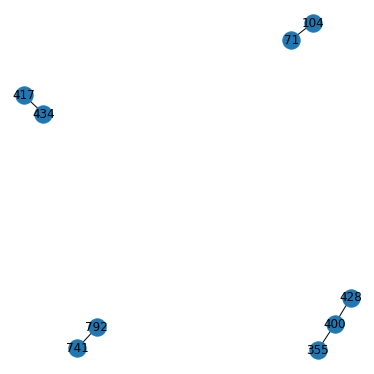

cluster  1


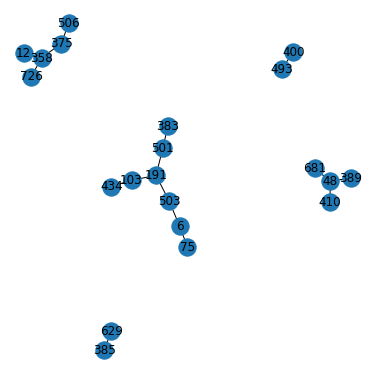

cluster  2


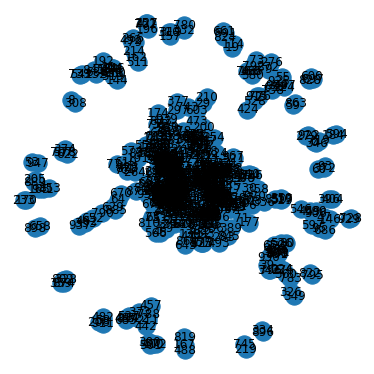

In [10]:
for i in common_75.keys():
    print("cluster ", i)
    T = ga.pattern_matching.build_graph_remove_isolates(common_75[i])
    
    plt.figure(3,figsize=(5,5)) 
    nx.draw(T, with_labels = True)
    plt.show()

In [11]:
#which edges are in 50% of all graphs in a cluster?

common_50 = {}

for cl in clusters_adjacencymatrices.keys():
    common_50[cl] = ga.pattern_matching.get_common_subgraph(clusters_adjacencymatrices[cl], p=0.5)

cluster  0


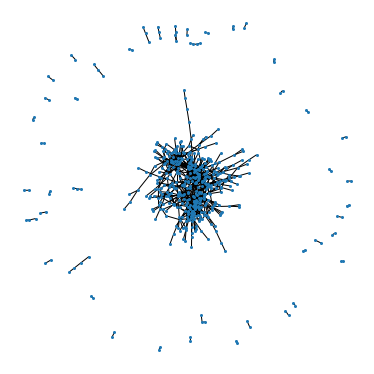

cluster  1


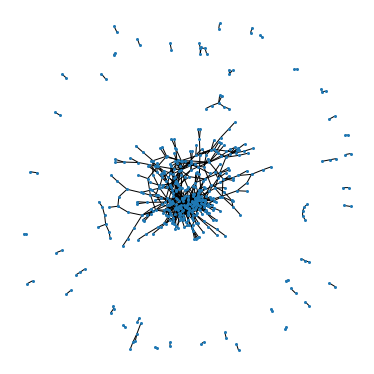

cluster  2


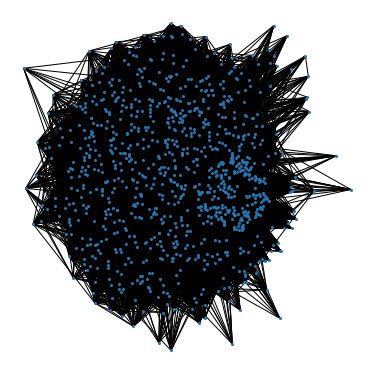

In [12]:
for i in common_50.keys():
    print("cluster ", i)
    T = ga.pattern_matching.build_graph_remove_isolates(common_50[i])
    
    plt.figure(3,figsize=(5,5)) 
    nx.draw(T, with_labels = False, node_size = 4)
    plt.show()

This method is easy and provides a fast overview if networks withing a cluster share many edges or not, but does not provide any information about the edge distribution within a cluster and between clusters.


Therefore next we are estimating a subgraph based on if a specific edge within a cluster is statistically significant enriched in that cluster. The function estimates p values for each edge within a cluster based on a hypergeometric function and performs correction based on a Benjamin Hochberg correction. Both values are returned.

In [13]:
pval_matrix, adj_pval_matrix = ga.pattern_matching.get_statistical_overrepresented_edges(clusters_adjacencymatrices)

cluster  1
number nodes 977
number edges 476776


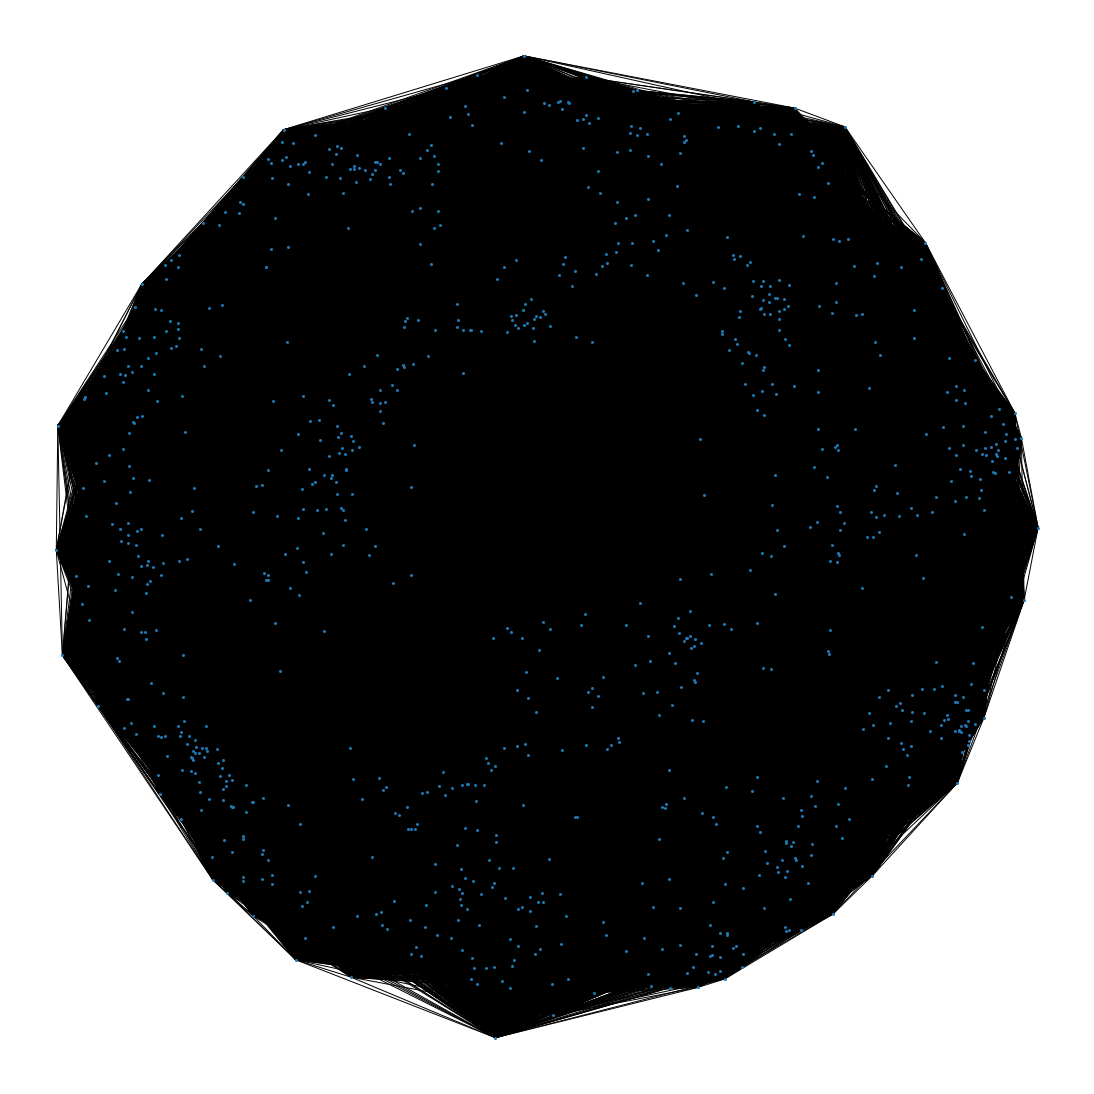

cluster  2
number nodes 977
number edges 476776


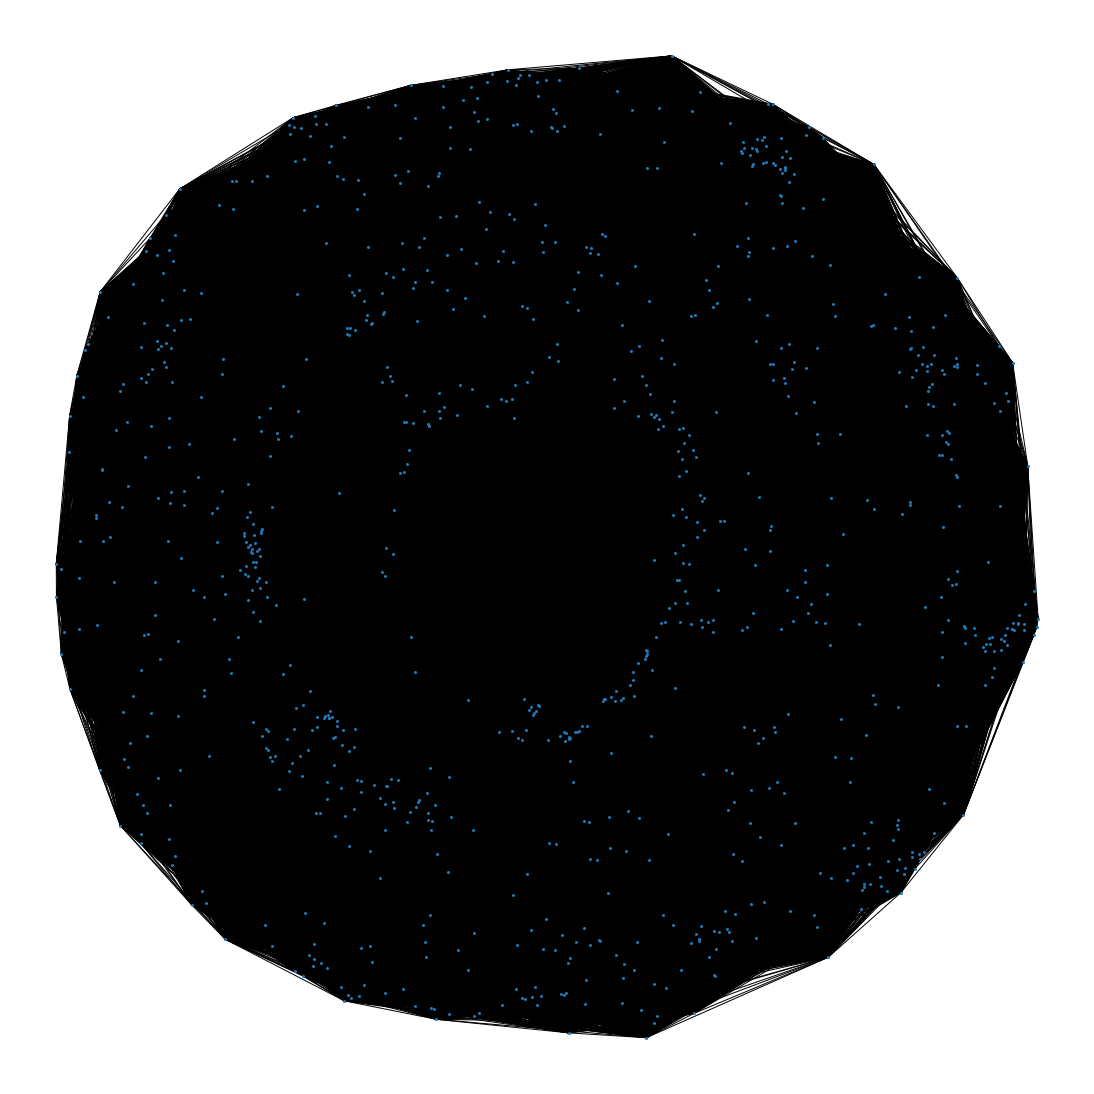

cluster  3
number nodes 977
number edges 476776


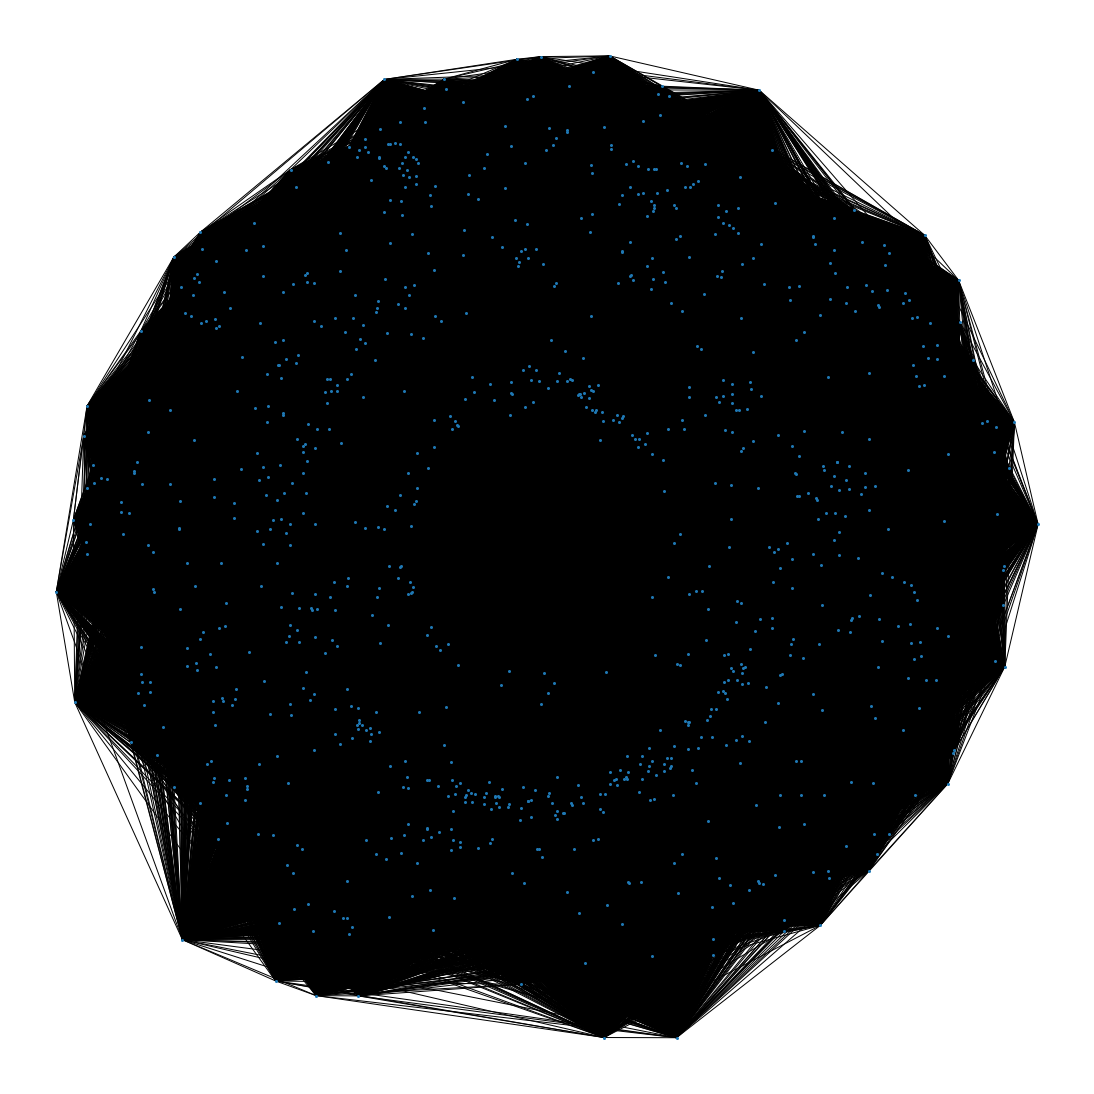

In [14]:
for i in adj_pval_matrix.keys():
    print("cluster ", i)
    
    T = ga.pattern_matching.build_graph_remove_isolates(adj_pval_matrix[i])
    print("number nodes", len(T.nodes()))
    print("number edges", len(T.edges()))
    plt.figure(3,figsize=(15,15)) 
    nx.draw(T, with_labels = False, node_size = 4)
    plt.show()

The estimated subgraphs can be used in replacement for all networks withing a cluster. Nodes & edges can be directly compared as described in network-network comparison or modules can be detected and functionally enriched as described in community detection.

# Communities

Here consensus communities on all graphs within a network group as well as statistical overrepresented communities within a network group are calculated.
For individual community detection algorithms or ensembl methods as well as on their application on individual networks please refer to the community detection example file.

## Statistical overrepressented communities within a network group

TODO: test updated function from package + try with provided partitioning based on another algorithm

In [15]:
statistical_communities = ga.pattern_matching.get_statistical_overrepresented_communities(clusters_networks, nodes, pval=0.05)

0
1
2


Are there statistical enriched communities with at least 20 nodes per cluster? What are their nodes?

In [16]:
stat_communities = {}

for cl in statistical_communities.keys():
    stat_communities[cl] = {}
    print("cluster", cl)
    for c in Counter(statistical_communities[cl]).keys():
        if Counter(statistical_communities[cl])[c] >= 20:
            print("community ", c, "has", Counter(statistical_communities[cl])[c], "nodes")
            
            
            temp = []
            for i in range(len(nodes)):
                if statistical_communities[cl][i] == c:
                    temp.append(nodes[i])
                    
            stat_communities[cl][c] = temp

cluster 1
community  2 has 23 nodes
community  16 has 30 nodes
community  41 has 24 nodes
cluster 2
community  0 has 680 nodes
cluster 3
community  1 has 22 nodes
community  4 has 26 nodes
community  5 has 32 nodes
community  7 has 29 nodes
community  8 has 21 nodes
community  10 has 27 nodes
community  11 has 22 nodes
community  12 has 33 nodes
community  14 has 28 nodes
community  15 has 53 nodes
community  18 has 31 nodes
community  19 has 45 nodes
community  20 has 28 nodes
community  21 has 23 nodes
community  23 has 46 nodes
community  24 has 25 nodes
community  26 has 28 nodes
community  27 has 23 nodes
community  28 has 43 nodes
community  32 has 23 nodes
community  33 has 31 nodes
community  37 has 21 nodes
community  40 has 29 nodes
community  49 has 20 nodes


These communities can now for example be functionally enriched.

## Consensus Community on a group of networks

For each network Louvain community detection is performed 10 times. Out of the partitionings for all networks in a group a consensus is estimated. The consensus is estimated based on clustering.consensus_clustering(), as explained in more detail in the Network clustering pipeline.

TODO: try with modified function and provided pre-estimated communities

In [18]:
consensus = {}

for cl in clusters_networks.keys():
    cons = ga.pattern_matching.get_consensus_community(clusters_networks[cl], nodes,  rep_network=10, threshold=0.75)
    
    consensus[cl] = cons

start removing
removing  252687
rerun
start removing
removing  151086
start removing
removing  317655
rerun
start removing
removing  114146
rerun
start removing
removing  59035
start removing
removing  123437
rerun
start removing
removing  72646


In [19]:
consensus

{0: array([0, 0, 1, 2, 3, 2, 2, 4, 2, 2, 1, 4, 2, 0, 0, 0, 2, 2, 4, 0, 0, 2,
        3, 5, 0, 4, 4, 0, 1, 5, 2, 5, 4, 4, 3, 1, 1, 4, 3, 0, 5, 0, 0, 0,
        4, 0, 5, 2, 4, 2, 4, 5, 5, 0, 2, 0, 5, 0, 5, 5, 2, 2, 0, 0, 5, 2,
        4, 3, 0, 0, 2, 4, 2, 3, 0, 0, 5, 0, 1, 1, 0, 3, 0, 0, 2, 2, 0, 0,
        2, 3, 0, 1, 3, 5, 2, 1, 3, 0, 5, 0, 0, 5, 4, 5, 4, 4, 0, 1, 3, 0,
        0, 0, 5, 4, 2, 1, 0, 5, 0, 2, 5, 1, 1, 0, 2, 0, 0, 0, 1, 5, 3, 3,
        2, 3, 1, 0, 5, 4, 2, 0, 5, 0, 2, 0, 3, 0, 0, 3, 1, 4, 0, 5, 1, 0,
        1, 5, 0, 5, 3, 3, 2, 3, 2, 2, 0, 4, 1, 5, 0, 5, 2, 5, 0, 3, 0, 4,
        5, 2, 4, 1, 1, 1, 1, 5, 4, 0, 1, 5, 1, 0, 5, 4, 2, 1, 0, 1, 1, 5,
        1, 2, 5, 5, 0, 3, 0, 2, 0, 3, 0, 0, 3, 3, 4, 1, 5, 5, 0, 0, 1, 3,
        5, 0, 4, 4, 1, 5, 4, 0, 0, 0, 1, 1, 5, 0, 1, 1, 1, 0, 0, 4, 1, 2,
        0, 2, 0, 3, 0, 3, 0, 5, 3, 0, 1, 0, 0, 0, 0, 0, 4, 1, 5, 1, 1, 0,
        0, 3, 5, 1, 5, 0, 3, 0, 0, 3, 5, 1, 3, 0, 0, 3, 0, 3, 3, 0, 5, 4,
        5, 1, 3, 1, 0, 3, 0, 1, 0, 

For example the communities can be functionally enriched and compared between the clusters.
    